In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import torch
import string
import unicodedata
# try to load the json data
import json
import torch.nn as nn
import time
import torch.optim as optim
import torch.nn.functional as F
from random import choice, choices, shuffle

import matplotlib.pyplot as plt

assert torch.cuda.is_available()

In [2]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#https://drive.google.com/open?id=1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1axFOiWZPTm-ncltlFUWZIptLoTNdtlYg'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content with length "{}"'.format(len(downloaded.GetContentString())))

jsonObject = json.loads(downloaded.GetContentString())

print(type(jsonObject))
print(len(jsonObject))
print(jsonObject[0])

all_categories = []
articles_dict = dict()
for article in jsonObject:
    category = article["category"]
    if category not in all_categories:
        all_categories.append(category)
        articles_dict[category] = []
    articles_dict[category].append(article)
    
n_categories = len(articles_dict.keys())

weights_all_categories = []
for category in all_categories:
    print("{} : {}".format(category, len(articles_dict[category])))
    weights_all_categories.append(len(articles_dict[category])/len(jsonObject))
print(weights_all_categories)

n_letters = len(string.printable)+1

def lineToCNNTensor(text):
    tensor = torch.zeros(1, len(text), n_letters)
    # this is splitting letters with accents into letter + accent
    normalized = unicodedata.normalize("NFD", text)
    for idx, char in enumerate(normalized):
        if unicodedata.category(char) == "Mn":
            continue
        # characters not in string.printable get a "pos" of -1,
        # which goes into the "trash" coordinate
        pos = string.printable.find(char)
        tensor[0, idx, pos] = 1
    return tensor

print(lineToCNNTensor("Ro"))
print(lineToCNNTensor("ro").shape)

use_characters = 300

Downloaded content with length "669380879"
<class 'list'>
573371
{'id': 'http://arxiv.org/abs/1904.03835v4', 'category': 'Physics', 'subject': 'astro-ph.CO', 'title': 'Kaon oscillations and baryon asymmetry of the universe', 'abstract': 'Baryon asymmetry of the universe (BAU) is naturally explained with\n$K^0-K^{0\'}$ oscillations of a newly developed mirror-matter model and new\nunderstanding of quantum chromodynamics (QCD) phase transitions. A consistent\npicture for the origin of both BAU and dark matter is presented with the aid of\n$n-n\'$ oscillations of the new model. The global symmetry breaking transitions\nin QCD are proposed to be staged depending on condensation temperatures of\nstrange, charm, bottom, and top quarks in the early universe. The long-standing\nBAU puzzle can then be understood with $K^0-K^{0\'}$ oscillations that occur at\nthe stage of strange quark condensation and baryon number violation via a\nnon-perturbative instanton-like (coined "quarkiton") process. S

In [4]:
class CNN_model(nn.Module):
    def __init__(self, abstract_length, characters_used, output_size):
        super(CNN_model, self).__init__()

        self.abstract_length = abstract_length
        self.characters_used = characters_used
        self.output_size = output_size
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 6, 10)
        self.conv2 = nn.Conv2d(6, 12, 10)
        # final dimensions
        fin_dim = (((abstract_length-9)//2-9)//2, ((characters_used-9)//2-9)//2)
        self.fin_dim = fin_dim
        self.linear1 = nn.Linear(12*fin_dim[0]*fin_dim[1], 4*fin_dim[0]*fin_dim[1])
        self.linear2 = nn.Linear(4*fin_dim[0]*fin_dim[1], output_size)

    def forward(self, x):
        # let AL stand for abstract length and CU for characters used
        ### each batch element has size (1, AL, CU)
        x = F.relu(self.conv1(x))
        ### each batch element has size (6, AL-10+1, CU-10+1)
        x = self.pool(x)
        ### each batch element has size (6, (AL-9)//2, (CU-9)//2)
        x = F.relu(self.conv2(x))
        ### size (12, (AL-9)//2-9, (CU-9)//2-9)
        x = self.pool(x)
        ### size (12, ((AL-9)//2-9)//2, ((CU-9)//2-9))//2)
        x = x.view(-1, 12*self.fin_dim[0]*self.fin_dim[1])
        x = self.linear2(F.relu(self.linear1(x)))
        return x
      
model = CNN_model(use_characters, n_letters, n_categories).cuda()

inp = lineToCNNTensor("Rodrigo is my name because that is what my parents decided to call me and starting up from here this is just some random gibberish trash because I really need this to be long enough otherwise it will not have enough charaters and the test will scream at me because dimensions do not match... OMG this was still not long enough..."[:300])
inp.unsqueeze_(0)
print(inp.shape)
output = model(inp.cuda())
print(output)

def categoryFromOutput(out):
    top_n, top_i = out.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomCNNTrainingExample(use_first_n_characters=-1):
    category = choice(all_categories)
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    article = choice(articles_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()
  
def randomWeightedCNNTrainingExample(use_first_n_characters=-1):
    # use the random.choices function with the weights computed earlier
    category = choices(all_categories, weights = weights_all_categories, k = 1)[0]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).cuda()
    article = choice(articles_dict[category])
    abstract = article["abstract"][:use_first_n_characters]
    abstract_tensor = lineToCNNTensor(abstract)
    return category, abstract, category_tensor.cuda(), abstract_tensor.cuda()

randomWeightedCNNTrainingExample()

def plot_losses(all_losses):
    plt.figure()
    plt.plot(all_losses)
    
def timeSince(since):
    now = time.time()
    s = now - since
    m = s//60
    s -= m*60
    return "{}m {}s".format(m, s)

torch.Size([1, 1, 300, 101])
tensor([[ 0.0145,  0.0084, -0.0081, -0.0129, -0.0016,  0.0141, -0.0037, -0.0161]],
       device='cuda:0', grad_fn=<AddmmBackward>)


## CNN model

100 1.0% (0.0m 9.84642219543457s) 2.076 / Physics X Quantitative Biology
200 2.0% (0.0m 19.71532893180847s) 2.069 / Mathematics X Electrical Engineering and Systems Science
300 3.0% (0.0m 29.43614649772644s) 2.104 / Mathematics X Quantitative Biology
400 4.0% (0.0m 39.17781114578247s) 2.077 / Quantitative Finance X Physics
500 5.0% (0.0m 49.01774787902832s) 2.091 / Physics X Electrical Engineering and Systems Science
600 6.0% (0.0m 58.77385497093201s) 2.068 / Electrical Engineering and Systems Science X Computer Science
700 7.0% (1.0m 8.662851095199585s) 2.089 / Computer Science V
800 8.0% (1.0m 18.463399410247803s) 2.088 / Electrical Engineering and Systems Science X Physics
900 9.0% (1.0m 28.31827163696289s) 2.062 / Quantitative Biology X Physics
1000 10.0% (1.0m 38.085222005844116s) 2.073 / Quantitative Biology X Quantitative Finance
1100 11.0% (1.0m 47.86131000518799s) 2.075 / Quantitative Finance X Quantitative Biology
1200 12.0% (1.0m 57.61471128463745s) 2.066 / Computer Science 

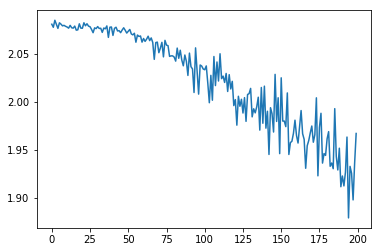

In [0]:
learning_rate = 0.001
model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

n_batch_iters = 10000
batch_size = 10
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_batch_iters+1):
  
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

## Increase learning rate

100 1.0% (0.0m 9.71642017364502s) 2.083 / Statistics X Computer Science
200 2.0% (0.0m 19.58099055290222s) 2.087 / Statistics X Physics
300 3.0% (0.0m 29.455525398254395s) 2.07 / Computer Science X Electrical Engineering and Systems Science
400 4.0% (0.0m 39.196889877319336s) 2.077 / Economics X Quantitative Biology
500 5.0% (0.0m 48.98391246795654s) 2.056 / Economics X Electrical Engineering and Systems Science
600 6.0% (0.0m 58.76623797416687s) 2.086 / Economics X Computer Science
700 7.0% (1.0m 8.41781234741211s) 2.085 / Economics X Electrical Engineering and Systems Science
800 8.0% (1.0m 18.150696277618408s) 2.106 / Economics X Statistics
900 9.0% (1.0m 27.852261781692505s) 2.097 / Quantitative Biology X Statistics
1000 10.0% (1.0m 37.575745582580566s) 2.067 / Quantitative Biology X Computer Science
1100 11.0% (1.0m 47.365379095077515s) 2.072 / Physics X Mathematics
1200 12.0% (1.0m 57.14902091026306s) 2.08 / Quantitative Biology X Mathematics
1300 13.0% (2.0m 6.9752960205078125s)

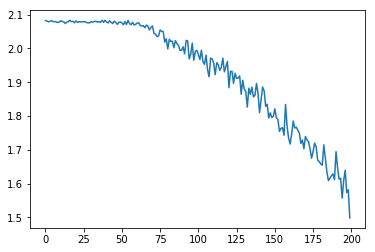

In [0]:
learning_rate = 0.003
model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

n_batch_iters = 10000
batch_size = 10
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_batch_iters+1):
  
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

## Increase learning rate again

100 1.0% (0.0m 9.864705085754395s) 2.083 / Mathematics X Quantitative Biology
200 2.0% (0.0m 19.640803575515747s) 2.055 / Quantitative Biology X Quantitative Finance
300 3.0% (0.0m 29.444040060043335s) 2.064 / Quantitative Biology X Quantitative Finance
400 4.0% (0.0m 39.29114127159119s) 2.073 / Quantitative Finance X Quantitative Biology
500 5.0% (0.0m 48.985100984573364s) 2.063 / Quantitative Biology X Economics
600 6.0% (0.0m 58.68861937522888s) 2.055 / Quantitative Biology X Mathematics
700 7.0% (1.0m 8.58617615699768s) 2.099 / Economics X Physics
800 8.0% (1.0m 18.382126569747925s) 2.085 / Economics X Quantitative Finance
900 9.0% (1.0m 28.13603949546814s) 2.083 / Computer Science X Physics
1000 10.0% (1.0m 37.947452545166016s) 2.083 / Computer Science X Quantitative Finance
1100 11.0% (1.0m 47.91018724441528s) 2.073 / Economics X Physics
1200 12.0% (1.0m 57.74798583984375s) 2.061 / Computer Science X Mathematics
1300 13.0% (2.0m 7.512393474578857s) 2.125 / Statistics X Mathematic

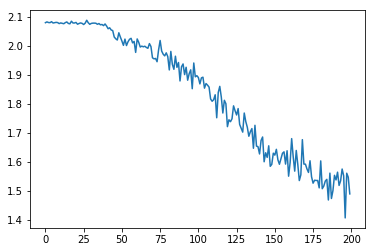

In [0]:
learning_rate = 0.005
model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

n_batch_iters = 10000
batch_size = 10
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_batch_iters+1):
  
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

## Revert learning rate, increase batch size

100 1.0% (0.0m 14.509258508682251s) 2.085 / Economics X Quantitative Finance
200 2.0% (0.0m 28.975743770599365s) 2.089 / Statistics V
300 3.0% (0.0m 43.42803359031677s) 2.085 / Physics X Computer Science
400 4.0% (0.0m 57.979403018951416s) 2.091 / Computer Science X Statistics
500 5.0% (1.0m 12.557959794998169s) 2.066 / Economics X Computer Science
600 6.0% (1.0m 26.94587516784668s) 2.078 / Electrical Engineering and Systems Science X Computer Science
700 7.0% (1.0m 41.396589040756226s) 2.081 / Economics X Physics
800 8.0% (1.0m 55.793179512023926s) 2.073 / Electrical Engineering and Systems Science X Quantitative Finance
900 9.0% (2.0m 10.303979635238647s) 2.07 / Quantitative Finance X Statistics
1000 10.0% (2.0m 24.77269220352173s) 2.099 / Economics X Quantitative Biology
1100 11.0% (2.0m 39.1905357837677s) 2.092 / Electrical Engineering and Systems Science V
1200 12.0% (2.0m 53.65197706222534s) 2.069 / Electrical Engineering and Systems Science V
1300 13.0% (3.0m 8.122886419296265s)

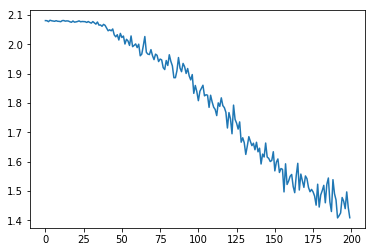

In [0]:
learning_rate = 0.003
model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

n_batch_iters = 10000
batch_size = 16
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_batch_iters+1):
  
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

## Double training time

100 0.5% (0.0m 14.535336256027222s) 2.073 / Statistics X Quantitative Biology
200 1.0% (0.0m 28.995806455612183s) 2.062 / Statistics X Electrical Engineering and Systems Science
300 1.5% (0.0m 43.40444731712341s) 2.085 / Quantitative Biology X Physics
400 2.0% (0.0m 57.86837196350098s) 2.092 / Quantitative Biology X Quantitative Finance
500 2.5% (1.0m 12.386359453201294s) 2.069 / Statistics X Mathematics
600 3.0% (1.0m 27.062721014022827s) 2.076 / Economics X Mathematics
700 3.5% (1.0m 41.73472571372986s) 2.079 / Quantitative Finance X Mathematics
800 4.0% (1.0m 56.3183171749115s) 2.067 / Quantitative Finance X Quantitative Biology
900 4.5% (2.0m 10.713636875152588s) 2.076 / Quantitative Biology X Computer Science
1000 5.0% (2.0m 25.206768035888672s) 2.062 / Physics X Electrical Engineering and Systems Science
1100 5.5% (2.0m 39.638869762420654s) 2.071 / Quantitative Biology V
1200 6.0% (2.0m 54.162585973739624s) 2.081 / Quantitative Biology X Statistics
1300 6.5% (3.0m 8.6261465549469

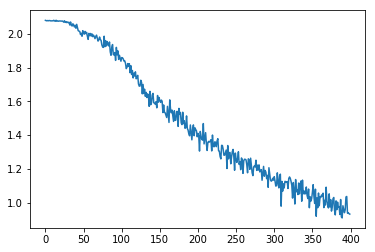

In [0]:
learning_rate = 0.003
model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

n_batch_iters = 20000
batch_size = 16
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_batch_iters+1):
  
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


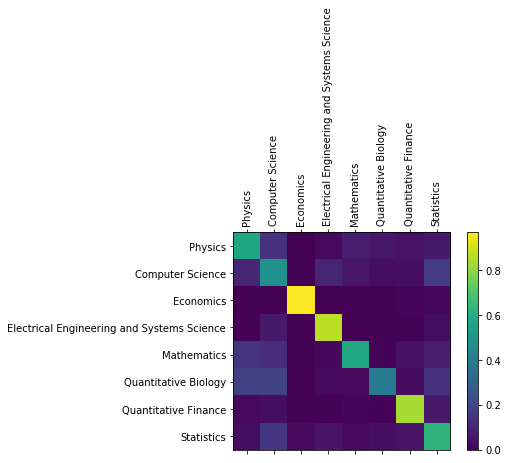

In [0]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    if 0 == i%(n_confusion//10):
        print(i)
    line = ""
    while len(line) < use_characters:
        category, line, category_tensor, line_tensor = randomCNNTrainingExample(use_characters)
    output = model(line_tensor.unsqueeze_(0))
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Go through ALL the data

545989
100 0.4% (0.0m 10.354270696640015s) 1.847 / Physics X Computer Science
200 0.8% (0.0m 20.85633635520935s) 1.4 / Physics X Mathematics
300 1.2% (0.0m 31.13886594772339s) 1.551 / Physics V
400 1.6% (0.0m 41.98573708534241s) 1.502 / Physics X Mathematics
500 2.0% (0.0m 52.478026151657104s) 1.499 / Physics X Mathematics
600 2.4% (1.0m 2.7651116847991943s) 1.562 / Mathematics V
700 2.8% (1.0m 12.991244792938232s) 1.343 / Physics X Computer Science
800 3.2% (1.0m 23.176512479782104s) 1.623 / Physics X Mathematics
900 3.6% (1.0m 33.38399362564087s) 1.357 / Mathematics V
1000 4.0% (1.0m 43.57379508018494s) 1.167 / Physics V
1100 4.4% (1.0m 53.878979206085205s) 1.449 / Physics X Mathematics
1200 4.8% (2.0m 4.257713317871094s) 1.389 / Computer Science X Physics
1300 5.2% (2.0m 14.544666528701782s) 1.628 / Physics X Computer Science
1400 5.6% (2.0m 24.764636278152466s) 1.419 / Physics V
1500 6.0% (2.0m 34.93791937828064s) 1.304 / Mathematics V
1600 6.4% (2.0m 45.057143211364746s) 1.253 / P

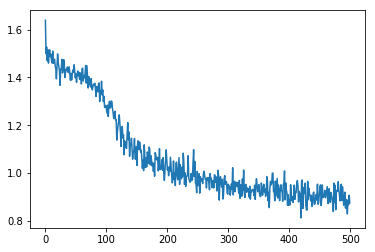

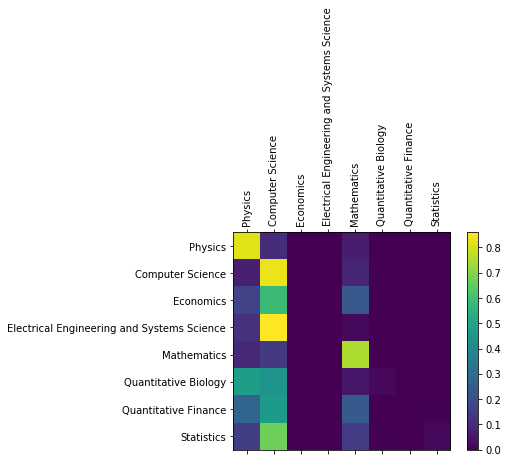

In [24]:
use_characters = 300
filteredAbstracts = list(filter(lambda art: len(art["abstract"])>= use_characters, jsonObject))
shuffle(filteredAbstracts)
print(len(filteredAbstracts))

training_data = 500000
test_data = len(filteredAbstracts) - training_data

learning_rate = 0.003
model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

batch_size = 20
print_every = 100
plot_every = 50

n_batch_iters = training_data//batch_size

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

batch_it = 0
for it in range(n_batch_iters):
  
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    for bi in range(batch_size):
        article = filteredAbstracts[it*batch_size + bi]
        category = article["category"]
        abstract = article["abstract"][:use_characters]
        out_batch[bi] = torch.tensor([all_categories.index(category)], dtype=torch.long)
        batch[bi, :, :, :] = lineToCNNTensor(abstract)
        
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not ((it+1) % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it+1, round((it+1)/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not ((it+1) % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

# confusion matrix with the rest
confusion = torch.zeros(n_categories, n_categories)
for article in filteredAbstracts[training_data+1:]:
    category = article["category"]
    abstract = article["abstract"][:use_characters]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    abstract_tensor = lineToCNNTensor(abstract).cuda()
    output = model(abstract_tensor.unsqueeze_(0))
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Back to random abstracts

100 0.33% (0.0m 10.597324132919312s) 2.076 / Economics V
200 0.67% (0.0m 21.143805503845215s) 2.081 / Quantitative Biology X Computer Science
300 1.0% (0.0m 31.70048761367798s) 2.069 / Quantitative Biology X Statistics
400 1.33% (0.0m 42.14002823829651s) 2.057 / Quantitative Finance V
500 1.67% (0.0m 52.58702540397644s) 2.075 / Quantitative Biology X Statistics
600 2.0% (1.0m 3.040393114089966s) 2.073 / Economics X Quantitative Biology
700 2.33% (1.0m 13.479337692260742s) 2.092 / Electrical Engineering and Systems Science X Mathematics
800 2.67% (1.0m 23.93923854827881s) 2.09 / Electrical Engineering and Systems Science X Computer Science
900 3.0% (1.0m 34.40994453430176s) 2.082 / Computer Science X Electrical Engineering and Systems Science
1000 3.33% (1.0m 44.903156757354736s) 2.105 / Economics X Electrical Engineering and Systems Science
1100 3.67% (1.0m 55.324206829071045s) 2.092 / Economics X Quantitative Finance
1200 4.0% (2.0m 5.751585483551025s) 2.087 / Statistics X Electrical 

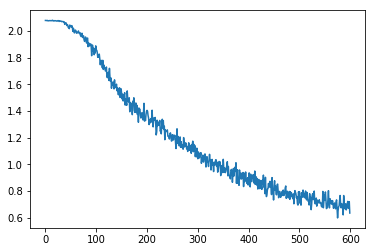

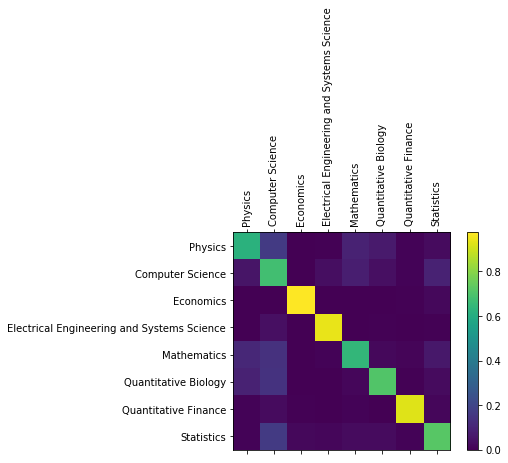

In [25]:
learning_rate = 0.003
model = CNN_model(use_characters, n_letters, n_categories).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

n_batch_iters = 30000
batch_size = 20
print_every = 100
plot_every = 50

# keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_batch_iters+1):
  
    batch = torch.zeros((batch_size, 1, use_characters, n_letters)).cuda()
    out_batch = torch.zeros(batch_size, dtype=torch.long).cuda()
    optimizer.zero_grad()
    bi = 0
    while bi < batch_size:
        category, abstract, category_tensor, abstract_tensor = randomCNNTrainingExample(use_characters)
        if len(abstract) < use_characters:
            continue
        batch[bi, :, :, :] = abstract_tensor
        out_batch[bi] = category_tensor
        bi += 1
            
    output = model(batch)
    loss = criterion(output, out_batch)
    loss.backward()
    current_loss += loss.item()
    optimizer.step()
    
    if not (it % print_every):
        guess, guess_i = categoryFromOutput(output)
        correct = "V" if guess == category else "X {}".format(category)
        print("{} {}% ({}) {:.4} / {} {}".format(it, round(it/n_batch_iters*100, 2), timeSince(start), loss, guess, correct))
        
    if not (it % plot_every):
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plot_losses(all_losses)

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    if 0 == i%(n_confusion//10):
        print(i)
    line = ""
    while len(line) < use_characters:
        category, line, category_tensor, line_tensor = randomCNNTrainingExample(use_characters)
    output = model(line_tensor.unsqueeze_(0))
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

import matplotlib.ticker as ticker
    
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [30]:
1000*confusion//10

tensor([[62., 16.,  0.,  0.,  9.,  7.,  1.,  2.],
        [ 5., 68.,  0.,  3.,  8.,  4.,  1.,  9.],
        [ 0.,  0., 97.,  0.,  0.,  0.,  0.,  2.],
        [ 0.,  3.,  0., 94.,  0.,  0.,  0.,  0.],
        [10., 13.,  0.,  1., 64.,  1.,  1.,  6.],
        [ 9., 14.,  0.,  0.,  1., 71.,  0.,  2.],
        [ 0.,  2.,  0.,  0.,  0.,  0., 92.,  1.],
        [ 0., 16.,  2.,  1.,  2.,  2.,  1., 72.]])